Look at the results of adding climate data. See the impact on performance for samples with satellite imagery vs. samples with only climate data

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import shutil
import yaml

from cloudpathlib import AnyPath
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
from zipfile import ZipFile

from cyano.data.utils import add_unique_identifier
from cyano.evaluate import (
    EvaluatePreds,
    generate_and_plot_crosstab,
    generate_actual_density_boxplot,
    generate_regional_barplot,
    generate_density_scatterplot,
    generate_density_kdeplot,
)

In [3]:
s3_dir = AnyPath("s3://drivendata-competition-nasa-cyanobacteria/experiments")

In [4]:
tmp_save_dir = AnyPath("tmp_data")
tmp_save_dir.mkdir(exist_ok=True, parents=True)

In [5]:
# load ground truth
true_path = s3_dir / "splits/competition/test.csv"
true = pd.read_csv(true_path, index_col=0)
true.shape

(6510, 9)

In [6]:
# load predictions
preds = pd.read_csv(
    s3_dir / "results/third_sentinel_and_climate/preds.csv", index_col=0
)
preds.shape

(6510, 5)

In [7]:
preds.head()

,date,latitude,longitude,log_density,severity
sample_id,,,,,
4a89ead93e2caa84da636236bb361e12,2016-08-31,36.559700,-121.51000,14.492519,4.0
a7e2d76f204ac347ae5529557eb7f665,2014-11-01,33.042600,-117.07600,9.964021,2.0
6afcb31acb56fc25af76983df6a60d0a,2015-08-26,40.703968,-80.29305,12.815983,3.0
494fb91d1fb8697e73b90e5d0c9420ed,2019-08-26,38.972500,-94.67293,10.569692,2.0
21e1f934b140745d1cde757090aa07fa,2018-01-08,34.279000,-118.90500,13.663097,3.0


In [8]:
preds.isna().sum()

date              0
latitude          0
longitude         0
log_density    1050
severity       1050
dtype: int64

### Save out subsets with / without satellite imagery

So that we can instantiate separate `EvaluatePreds` classes, save out two versions of the predictions -- one with only samples that have satellite imagery, one with only samples that *don't* have satellite imagery

In [9]:
# Load test features to see which samples had satellite imagery
test_features = pd.read_csv(
    s3_dir / "results/third_sentinel_and_climate/features_test.csv"
)
test_features.shape, test_features.sample_id.nunique()

((22128, 73), 5460)

In [10]:
test_features.head(2)

,sample_id,AOT_mean,AOT_min,AOT_max,AOT_range,B01_mean,B01_min,B01_max,B01_range,B02_mean,...,NDVI_B06,NDVI_B07,month,days_before_sample,TMP_min,TMP_mean,TMP_max,SPFH_min,SPFH_mean,SPFH_max
0,00028d54fa33b3b90a70eda38c1d94c4,126.0,126.0,126.0,0.0,685.530612,432.0,1742.0,1310.0,822.126417,...,0.068435,0.029072,9.0,6.0,288.82895,290.581756,292.12683,0.00823,0.010754,0.01257
1,00028d54fa33b3b90a70eda38c1d94c4,114.0,114.0,114.0,0.0,643.408163,351.0,1668.0,1317.0,819.565760,...,0.063530,0.019663,9.0,11.0,288.82895,290.581756,292.12683,0.00823,0.010754,0.01257


In [11]:
test_features.isna().sum()

sample_id      0
AOT_mean     636
AOT_min      636
AOT_max      636
AOT_range    636
            ... 
TMP_mean      25
TMP_max       25
SPFH_min      25
SPFH_mean     25
SPFH_max      25
Length: 73, dtype: int64

In [12]:
# all satellite features have the same number of missing values
test_features.isna().sum().value_counts()

636    66
25      6
0       1
Name: count, dtype: int64

In [13]:
test_features["has_climate"] = test_features.SPFH_max.notna()
test_features["has_satellite"] = test_features.AOT_mean.notna()

# how many samples have climate features?
test_features[test_features.has_climate].sample_id.nunique()

5444

In [14]:
# how many samples have satellite features?
test_features[test_features.has_satellite].sample_id.nunique()

4824

In [15]:
# all sample have either satellite or climate
test_features.groupby(
    ["has_climate", "has_satellite"], as_index=False
).sample_id.nunique()

,has_climate,has_satellite,sample_id
0,False,True,16
1,True,False,636
2,True,True,4808


In [16]:
preds_sat_path = tmp_save_dir / "preds_with_sat.csv"
preds_no_sat_path = tmp_save_dir / "preds_no_sat.csv"

In [17]:
# Save out subset with satellite imagery
preds_sat = preds.loc[test_features[test_features.has_satellite].sample_id.unique()]
print(preds_sat.shape)
preds_sat.to_csv(preds_sat_path, index=True)

(4824, 5)


In [18]:
# Save out subset without satellite imagery
preds_no_sat = preds.loc[test_features[~test_features.has_satellite].sample_id]
print(preds_no_sat.shape)
preds_no_sat.to_csv(preds_no_sat_path, index=True)

(636, 5)


In [19]:
# Load model
archive = ZipFile(s3_dir / "results/third_sentinel_and_climate/model.zip", "r")
model = lgb.Booster(model_str=archive.read("lgb_model.txt").decode())
type(model)

lightgbm.basic.Booster

### Instantiate `EvaluatePreds` classes

In [20]:
evals = {}
evals["with_satellite"] = EvaluatePreds(
    true_path, preds_sat_path, "tmp/eval_sat", model
)

2023-08-24 17:48:51.589 | INFO     | cyano.evaluate:__init__:131 - Evaluating on 4,824 samples (of 4,824)


In [21]:
evals["without_satellite"] = EvaluatePreds(
    true_path, preds_no_sat_path, "tmp/eval_sat", model
)

2023-08-24 17:48:51.773 | INFO     | cyano.evaluate:__init__:131 - Evaluating on 636 samples (of 636)


## Evaluate

### Severity level

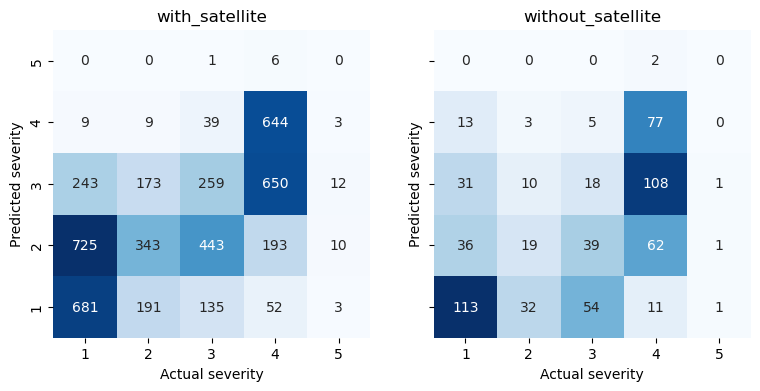

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)
for i, key in enumerate(evals.keys()):
    generate_and_plot_crosstab(
        evals[key].y_true_df.severity, evals[key].y_pred_df.severity, ax=axes[i]
    )
    axes[i].set_title(key)

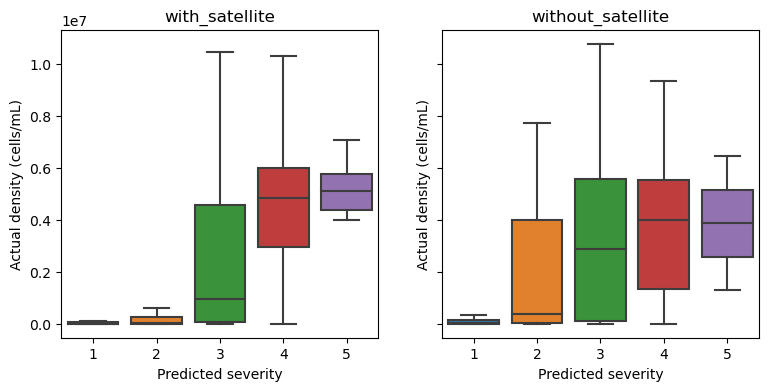

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)
for i, key in enumerate(evals.keys()):
    generate_actual_density_boxplot(
        evals[key].y_true_df.density_cells_per_ml,
        evals[key].y_pred_df.severity,
        ax=axes[i],
    )
    axes[i].set_title(key)

In [24]:
severity_results = {
    key: evalpreds.calculate_severity_metrics(
        y_true=evalpreds.y_true_df.severity,
        y_pred=evalpreds.y_pred_df.severity,
        region=evalpreds.region,
    )
    for key, evalpreds in evals.items()
}

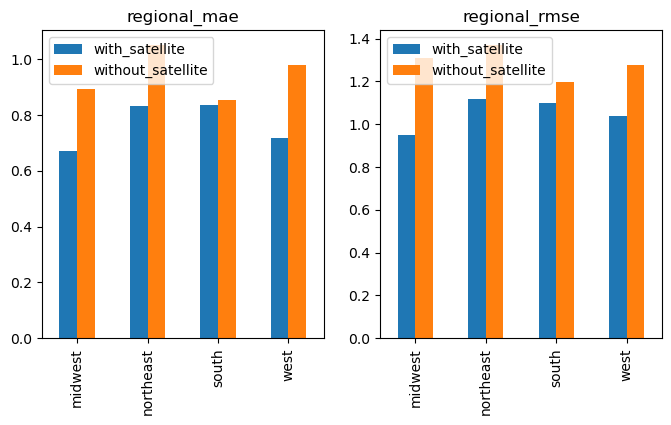

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for i, metric in enumerate(
    [
        "regional_mae",
        "regional_rmse",
    ]
):
    regional_scores = pd.DataFrame(
        {key: res[metric] for key, res in severity_results.items()}
    )
    regional_scores.plot(kind="bar", ax=axes[i])
    axes[i].set_title(metric)
plt.show()

In [26]:
# See RMSE in detail for regions
regional_scores

,with_satellite,without_satellite
midwest,0.949382,1.308208
northeast,1.119293,1.370759
south,1.101458,1.198117
west,1.038388,1.278409


In [27]:
pd.DataFrame(severity_results).loc[
    [
        "overall_rmse",
        "overall_mae",
        "overall_mape",
        "region_averaged_rmse",
    ]
]

,with_satellite,without_satellite
overall_rmse,1.047088,1.301306
overall_mae,0.754768,0.963836
overall_mape,0.413274,0.440592
region_averaged_rmse,1.05213,1.288873


### Log(density)

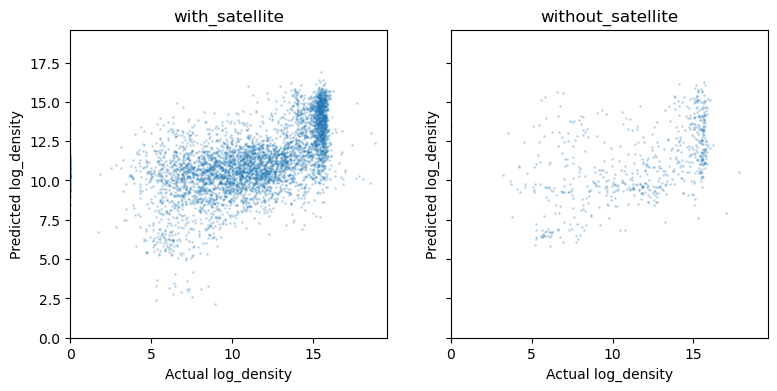

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)
for i, key in enumerate(evals.keys()):
    generate_density_scatterplot(
        evals[key].y_true_df.log_density, evals[key].y_pred_df.log_density, ax=axes[i]
    )
    axes[i].set_title(key)

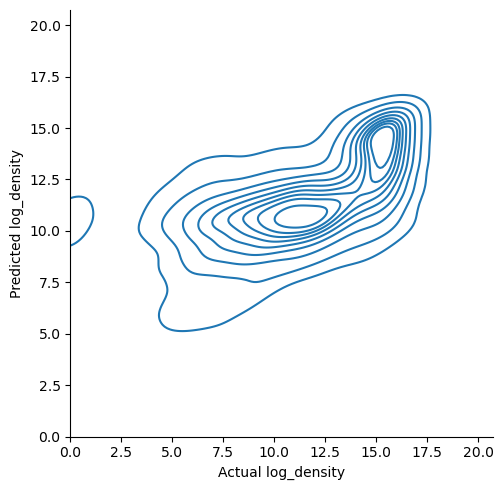

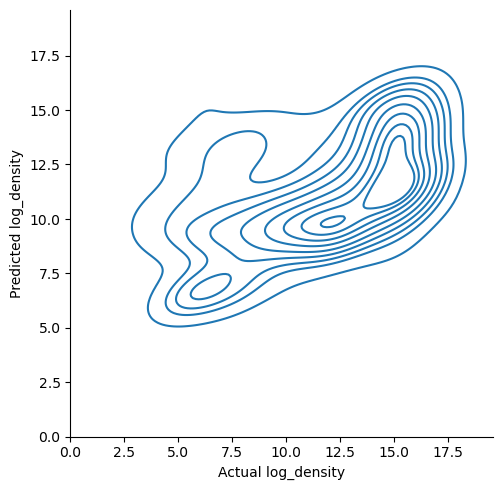

In [29]:
for i, key in enumerate(evals.keys()):
    generate_density_kdeplot(
        evals[key].y_true_df.log_density, evals[key].y_pred_df.log_density
    )

In [38]:
# log density metrics for just samples with satellite imagery
evals["with_satellite"].calculate_density_metrics(
    y_true=evals["with_satellite"].y_true_df.log_density,
    y_pred=evals["with_satellite"].y_pred_df.log_density,
    region=evals["with_satellite"].region,
)

{'overall_r_squared': 0.34855488896911635,
 'overall_mape': 816735947681822.8,
 'regional_r_squared': {'midwest': 0.20872661170638018,
  'northeast': -0.13424224725012124,
  'south': -0.2750732699263281,
  'west': -1.3050260319818223}}

### Feature importances

In [30]:
feature_importance = pd.read_csv(
    s3_dir / "results/third_sentinel_and_climate/metrics/feature_importance.csv",
    index_col=0,
)

# what are the top features by importance gain?
feature_importance.sort_values(by="importance_gain", ascending=False).head(10)

,importance_gain,importance_split
feature,,
TMP_max,269413.475085,1799
SPFH_max,239187.791676,1535
TMP_min,194581.212845,1705
TMP_mean,143884.032690,1609
B12_mean,127485.773876,488
SPFH_mean,98644.132898,1320
SPFH_min,97477.277260,1637
B01_max,94026.829602,235
month,89995.479400,717


In [31]:
# what are the top features by importance split?
feature_importance.sort_values(by="importance_split", ascending=False).head(10)

,importance_gain,importance_split
feature,,
TMP_max,269413.475085,1799
TMP_min,194581.212845,1705
SPFH_min,97477.277260,1637
TMP_mean,143884.032690,1609
SPFH_max,239187.791676,1535
SPFH_mean,98644.132898,1320
NDVI_B07,29927.593100,840
month,89995.479400,717
NDVI_B06,21011.006495,622


### Which new samples do we get features for?

Are we only covering additional older samples, or does climate data increase our coverage on newer samples as well? this helps determine whether the tradeoff of slight decrease in performance is worth the additional coverage moving forward. 

In [32]:
test = pd.read_csv(s3_dir / "splits/competition/test.csv")
test = add_unique_identifier(test)
test["date"] = pd.to_datetime(test.date)
test.head(2)

,uid,data_provider,region,latitude,longitude,date,density_cells_per_ml,severity,distance_to_water_m,log_density
sample_id,,,,,,,,,,
4a89ead93e2caa84da636236bb361e12,aabn,California Environmental Data Exchange Network,west,36.5597,-121.510,2016-08-31,5867500.0,4,3512.0,15.584939
a7e2d76f204ac347ae5529557eb7f665,aair,California Environmental Data Exchange Network,west,33.0426,-117.076,2014-11-01,2769000.0,4,195.0,14.833997


In [33]:
new_coverage = test.loc[test_features[~test_features.has_satellite].sample_id]
new_coverage.shape

(636, 10)

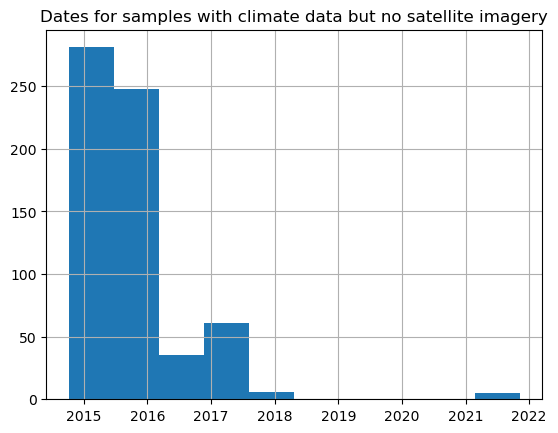

In [34]:
new_coverage.date.hist()
plt.title("Dates for samples with climate data but no satellite imagery")
plt.show()

In [35]:
new_coverage.date.dt.year.value_counts().sort_index()

date
2014     74
2015    453
2016     37
2017     67
2021      5
Name: count, dtype: int64

**Takeaway**

Most of the samples climate data enables us to cover are on the older side. There are almost none post-2017 that climate covers but satellite does not.

In [36]:
# delete temporary dir
shutil.rmtree(tmp_save_dir)